In [100]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt 

# 1. Read all data

In [27]:
obs = pd.read_csv('./data/beetle/artportalen/artportalen_final.csv')
obs["Month"] = pd.to_datetime(obs['Date']).dt.to_period("M").dt.to_timestamp()
print(f"Datapoints (observations): {len(obs)}")
obs.head(5)

Datapoints (observations): 5022


,row_id,Lat,Lon,Date,Kommun,Lan,Quantity,Pressence,Month
0,0,58.788614,15.821428,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
1,1,58.788632,15.817157,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
2,2,58.786980,15.816672,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
3,3,58.786361,15.815842,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
4,4,58.835413,15.509221,2021-05-12 00:00:00,Finspång,Östergötland,1,0,2021-05-01


In [ ]:
try:
    weather_features = pd.read_csv('./data/weather_monthly/weather_final.csv')
    weather_features['Month'] = pd.to_datetime(weather_features['Month'])
    print(f"Datapoints (weather): {len(weather_features)}")
    print(weather_features.head(5))
except:
    pass # TODO: RUN data_weather.ipynb

try:
    ndvi_features = pd.read_csv('./data/ndvi/ndvi_final.csv')
    ndvi_features['Month'] = pd.to_datetime(ndvi_features['Month'])
    print(f"Datapoints (NDVI): {len(ndvi_features)}")
    print(ndvi_features.head(5))
except:
    pass # TODO: RUN data_ndvi.ipynb


Datapoints (weather): 4862
Datapoints (NDVI): 5022


### Combine all data into 1 dataset

In [71]:
dataset = obs.merge(ndvi_features, on=[ "Lat", "Lon","row_id", "Month"], how="left")
dataset = dataset.merge(weather_features, on=["Lat", "Lon","row_id", "Month"], how="left")
dataset.dropna(axis=0,inplace=True)
print(f"Dataset has {len(dataset)} datapoints.")
dataset.head()

Dataset has 4843 datapoints.


,row_id,Lat,Lon,Date,Kommun,Lan,Quantity,Pressence,Month,NDVI,...,NDVI_anom,NDVI_lag1,NDVI_anom_lag1,NDVI_lag2,NDVI_anom_lag2,t2m,tp,swvl1,swvl2,ssrd
0,0,58.788614,15.821428,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01,0.67775,...,-0.034606,0.71975,0.115750,0.45875,-0.177544,278.06323,0.001367,0.245316,0.247009,15851508.0
1,1,58.788632,15.817157,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01,0.69475,...,0.004012,0.71860,0.103387,0.45815,-0.176888,278.06323,0.001367,0.245316,0.247009,15851508.0
2,2,58.786980,15.816672,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01,0.64620,...,-0.006687,0.66210,0.093669,0.66210,0.093669,278.06323,0.001367,0.245316,0.247009,15851508.0
3,3,58.786361,15.815842,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01,0.64620,...,-0.006687,0.64620,-0.006687,0.66210,0.093669,278.06323,0.001367,0.245316,0.247009,15851508.0
4,4,58.835413,15.509221,2021-05-12 00:00:00,Finspång,Östergötland,1,0,2021-05-01,0.64880,...,-0.029956,0.51110,-0.088069,0.61880,0.030450,283.59570,0.004811,0.261627,0.261032,16841360.0


# 2. Train model

### Prepare training and validation sets.
Due to chronological nature we sort by date (Month) and use the first 80% of datapoints as training and last 20% as test to reduce risk of data leakage.

In [90]:
dataset = dataset.sort_values("Month")

non_feature_cols = ["Pressence", "Date", "Kommun", "Lan", "Month", "row_id", "Lat", "Lon"]

y = dataset["Pressence"]
X = dataset.drop(columns=non_feature_cols)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=71)

print(f"Train rows: {len(X_train)}, Test rows: {len(X_valid)}")
print(f"Number of Features: {len(X_train.columns)}")

Train rows: 3874, Test rows: 969
Number of Features: 13


In [ ]:
# # Sort by Month to ensure chronological order
# dataset = dataset.sort_values("Month")
# unique_months = dataset["Month"].sort_values().unique()
# cut_idx = int(len(unique_months) * 0.8)
# #cut_idx = int(len(unique_months) * 0.8)
# train_months = unique_months[:cut_idx]
# valid_months = unique_months[cut_idx:]

# train_mask = dataset["Month"].isin(train_months)
# valid_mask = dataset["Month"].isin(valid_months)

# train_df = dataset.loc[train_mask].copy()
# valid_df = dataset.loc[valid_mask].copy()

# # Features/target
# target_col = "Pressence"
# non_feature_cols = [target_col, "Date", "Kommun", "Lan", "Month", "row_id", "Lat", "Lon"]
# feature_cols = [c for c in X.columns if c not in non_feature_cols]

# X_train = train_df[feature_cols]
# y_train = train_df[target_col]
# X_valid = valid_df[feature_cols]
# y_valid = valid_df[target_col]

# print(f"Train rows: {len(train_df)}, Valid rows: {len(valid_df)}")
# print(f"Features: {len(feature_cols)}")


### Z-Normalize features

In [91]:
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_valid = (X_valid - X_valid.mean(axis=0)) / X_valid.std(axis=0)

### Train XGBoost

In [103]:
# Train and evaluate XGBoost
params = {
    "n_estimators": 400,
    "booster":'gbtree',
    "max_depth": 7,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "binary:logistic",
    "eval_metric": "auc",
}

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
roc = roc_auc_score(y_valid, y_pred)
ap = accuracy_score(y_valid, y_pred)

print(f"Validation ROC-AUC: {roc:.4f}")
print(f"Validation Average Precision: {ap:.4f}")


Validation ROC-AUC: 0.7769
Validation Average Precision: 0.8958


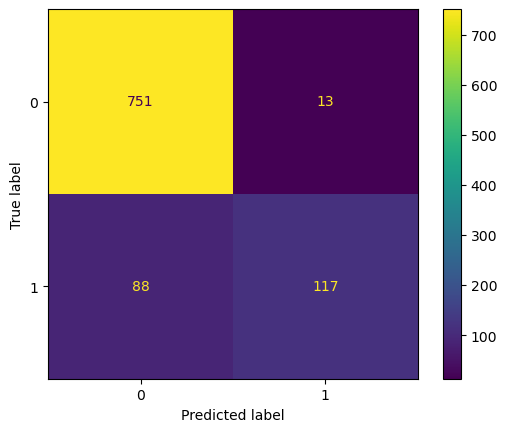

In [107]:
cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()
